<a href="https://colab.research.google.com/github/GianRomani/Neural_search_engine/blob/main/Romani_DM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not working on Colab, it should work in local. It is needed to use GPU with multiprocess (in Flow)
%env JINA_MP_START_METHOD='spawn'
import os
import torch.multiprocessing as mp

print(os.getenv("JINA_MP_START_METHOD"))
mp.set_start_method('spawn', force=True)

env: JINA_MP_START_METHOD='spawn'
'spawn'


In [ ]:
try: 
  #this will raise an error if you are not using Colab
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("You are not using Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
questions = pd.read_csv("/content/drive/MyDrive/DM/Questions.csv", encoding="ISO-8859-1")
answers = pd.read_csv("/content/drive/MyDrive/DM/Answers.csv", encoding="ISO-8859-1")

index_outfile = "/content/drive/MyDrive/DM/index_1k.csv"

# EDA

It can be interesting and helpful to analyze:

*   the distribution of the scores among the questions,
*   number of answers for question (and scores of those answers);
*   creation dates for the posts;
*   if a post was closed (and why);
*   popular users (who answered a lot of questions)





<h2>Questions</h2>

*   Id: id of the question;
*   OwnerUserId: id of the account who post the question;
*   CreationDate: when the question was posted;
*   ClosedDate: when the question was closed;
*   Score: upvotes - downvotes;
*   Title: title of the question;
*   Body: the question

In [ ]:
questions.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [ ]:
questions.describe()

,Id,OwnerUserId,Score
count,1.264216e+06,1.249762e+06,1.264216e+06
mean,2.132745e+07,2.155177e+06,1.781537e+00
std,1.151445e+07,1.801265e+06,1.366389e+01
min,8.000000e+01,1.000000e+00,-7.300000e+01
25%,1.142598e+07,6.589110e+05,0.000000e+00
50%,2.172542e+07,1.611830e+06,0.000000e+00
75%,3.154542e+07,3.353792e+06,1.000000e+00
max,4.014338e+07,7.046594e+06,5.190000e+03


In [ ]:
#What is the distribution of the scores among the questions?
score_distribution = questions["Score"].value_counts(bins=20)
score_distribution

(-78.26400000000001, 190.15]    1263601
(190.15, 453.3]                     478
(453.3, 716.45]                      78
(716.45, 979.6]                      30
(979.6, 1242.75]                     11
(1505.9, 1769.05]                     9
(1242.75, 1505.9]                     4
(2295.35, 2558.5]                     3
(3611.1, 3874.25]                     1
(4926.85, 5190.0]                     1
(2032.2, 2295.35]                     0
(2821.65, 3084.8]                     0
(3084.8, 3347.95]                     0
(3347.95, 3611.1]                     0
(1769.05, 2032.2]                     0
(3874.25, 4137.4]                     0
(4137.4, 4400.55]                     0
(4400.55, 4663.7]                     0
(4663.7, 4926.85]                     0
(2558.5, 2821.65]                     0
Name: Score, dtype: int64

In [ ]:
#negative scores
negative_scores_questions = questions[questions["Score"] < 0]
negative_scores_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
487,43960,3262.0,2008-09-04T15:07:30Z,NaN,-1,COTS Workshop Registration System,<p>Does anyone have any experience with any CO...
890,73260,12550.0,2008-09-16T14:57:37Z,NaN,-1,What is your choice for a Time Managment Solut...,<p>I've come across a few different applicatio...
904,74570,7709.0,2008-09-16T17:02:14Z,NaN,-1,CSS : Bad Gray Line to the side of the Navigat...,"<p>I'm maintaining <a href=""http://perl-begin...."
949,79350,NaN,2008-09-17T02:37:37Z,2015-06-23T23:33:20Z,-1,What open source virtual private server progra...,<p>I am looking to have 4 Virtual servers(vari...
1017,85370,6992.0,2008-09-17T17:01:08Z,NaN,-2,"Most common cause of ""java.lang.NullPointerExc...",<p>My strongest lead is that the code who deal...
...,...,...,...,...,...,...,...
1264187,40142600,7044841.0,2016-10-19T22:33:00Z,2016-10-19T22:34:48Z,-10,Remove white spaces without replace(),<pre><code>def compress(s):\n âââ(str...
1264188,40142610,7037290.0,2016-10-19T22:34:23Z,NaN,-1,"How to get a direct, secure url (XXX.mp3) for ...",<p>So I can pull the url for a track from the ...
1264193,40142780,4957922.0,2016-10-19T22:52:04Z,NaN,-4,Sparse Arrays in Data Structure,<p>I am solving the following problem in C : \...
1264194,40142790,7044882.0,2016-10-19T22:52:53Z,2016-10-19T23:05:09Z,-5,Why is my switch statement giving me constant ...,<p>Sorry in advance for the weird format of th...


In [ ]:
#Posts with a score greater than 4000
best_posts = questions[questions["Score"] >4000]
best_posts

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
4907,348170,14069.0,2008-12-07T21:57:46Z,NaN,5190,How to undo 'git add' before commit?,<p>I mistakenly added files using the command:...


In [ ]:
#Count NaN values -> most of them in ClosedDate
questions.isna().sum()

Id                    0
OwnerUserId       14454
CreationDate          0
ClosedDate      1208257
Score                 0
Title                 0
Body                  0
dtype: int64

<h2>Answers</h2>


*   Id: id of the answer;
*   OwnerUserId: id of the account who post the answer;
*   CreationDate: when the answer was posted;
*   ParentId: Id of the question;
*   Score: upvotes - downvotes;
*   Body: the answer



In [ ]:
answers.head(10)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi..."
8,473,49.0,2008-08-02T15:33:13Z,470,8,"<p>No, what you're doing is fine. Don't let th..."
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...


In [ ]:
answers.describe()

,Id,OwnerUserId,ParentId,Score
count,1.202323e+06,1.194434e+06,1.202323e+06,1.202323e+06
mean,1.761983e+07,1.245753e+06,1.676039e+07,4.197150e+00
std,1.152457e+07,1.397284e+06,1.154135e+07,2.041301e+01
min,9.200000e+01,1.000000e+00,8.000000e+01,1.000000e+00
25%,7.508626e+06,2.048470e+05,6.576165e+06,1.000000e+00
50%,1.632720e+07,7.311740e+05,1.507235e+07,2.000000e+00
75%,2.732021e+07,1.769784e+06,2.622150e+07,3.000000e+00
max,4.014332e+07,7.045028e+06,4.014319e+07,5.718000e+03


In [ ]:
#Distribution for the scores of the answers
score_distribution = answers["Score"].value_counts(bins=20)
score_distribution

(-4.718, 286.85]     1201603
(286.85, 572.7]          522
(572.7, 858.55]          123
(858.55, 1144.4]          29
(1430.25, 1716.1]         15
(1144.4, 1430.25]         11
(1716.1, 2001.95]          5
(2001.95, 2287.8]          5
(2859.5, 3145.35]          4
(2287.8, 2573.65]          2
(3431.2, 3717.05]          2
(2573.65, 2859.5]          1
(5432.15, 5718.0]          1
(3145.35, 3431.2]          0
(3717.05, 4002.9]          0
(4002.9, 4288.75]          0
(4288.75, 4574.6]          0
(4574.6, 4860.45]          0
(4860.45, 5146.3]          0
(5146.3, 5432.15]          0
Name: Score, dtype: int64

In [ ]:
#negative scores
negative_scores_answers = answers[answers["Score"] < 0]
negative_scores_answers

In [ ]:
#Number of answers for question
answers_for_post = answers.groupby(["ParentId"]).count()["Id"]
answers_for_post

ParentId
80          3
90          3
120         1
180         7
260         9
           ..
40142470    1
40142550    1
40142580    1
40142940    1
40143190    1
Name: Id, Length: 772051, dtype: int64

In [ ]:
#max number of answers for a post
answers_for_post.max()

384

In [ ]:
#How many questions have a certain number of answers?
print("#answers   #questions")
answers_for_post.value_counts()

#answers   #questions


1      514847
2      165761
3       54312
4       19887
5        8116
6        3869
7        1878
8        1142
9         704
10        442
11        309
12        194
13        126
14        103
15         89
16         48
17         41
19         31
18         28
21         20
20         16
22         14
24         11
26          9
27          8
25          8
23          6
28          5
31          5
29          3
46          2
36          2
32          2
49          1
61          1
384         1
30          1
33          1
37          1
34          1
84          1
122         1
59          1
259         1
41          1
35          1
Name: Id, dtype: int64

In [ ]:
#How many NaN values?
answers.isna().sum()

Id                 0
OwnerUserId     7889
CreationDate       0
ParentId           0
Score              0
Body               0
dtype: int64

In [ ]:
#How many questions were answered by the users?
users_and_number_of_answers = answers["OwnerUserId"].value_counts()
print("UserId     #answers")
users_and_number_of_answers

UserId     #answers


22656.0      3151
1144035.0    2024
29407.0      1798
100297.0     1555
17034.0      1533
             ... 
2194410.0       1
2493216.0       1
2493190.0       1
2493257.0       1
7045028.0       1
Name: OwnerUserId, Length: 291512, dtype: int64

In [ ]:
#Distribution of the number of answers posted by different users
print("#answers    #users")
users_and_number_of_answers.value_counts()

#answers    #users


1       169695
2        44596
3        20732
4        12435
5         8124
         ...  
341          1
340          1
334          1
329          1
3151         1
Name: OwnerUserId, Length: 399, dtype: int64

<h2>Tags</h2>


*   Id: id of the question
*   Tag: just the tag :)



In [ ]:
tags = pd.read_csv("/content/drive/MyDrive/DM/Tags.csv", encoding="ISO-8859-1")

In [ ]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [ ]:
#How many rows?
tags.shape[0]

3750994

In [ ]:
#Check if there are some null values
tags.isna().sum()

Id        0
Tag    1113
dtype: int64

In [ ]:
#Number of tags for post
number_of_tags_for_post = tags["Id"].value_counts()
print("Post     #tags")
number_of_tags_for_post

Post     #tags


11053790    5
5221980     5
25573000    5
25573010    5
16468060    5
           ..
8240020     1
11770790    1
21883080    1
3949000     1
34943370    1
Name: Id, Length: 1264216, dtype: int64

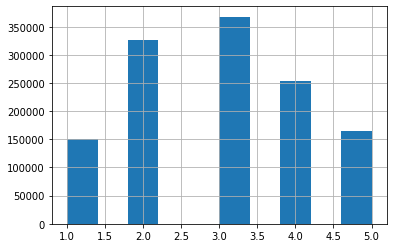

In [ ]:
#Distribution of number of tags
number_of_tags_for_post.hist()

In [ ]:
#Number of tags for post
tags_used = tags["Tag"].value_counts()
tags_used

javascript           124155
java                 115212
c#                   101186
php                   98808
android               90659
                      ...  
testcasesource            1
google-floodlight         1
iecapt                    1
netfs                     1
docker-windows            1
Name: Tag, Length: 37034, dtype: int64

In [ ]:
counter = 0
for i in tags_used:
  if i > 10:
    counter+=1
counter

14177

In [ ]:
#How many tags appear a certain number of times
print("#occurrences #tags")
occ_tags = tags_used.value_counts()
occ_tags

#occurrences #tags


1       6427
2       4148
3       2989
4       2245
5       1697
        ... 
1143       1
1139       1
1137       1
1136       1
671        1
Name: Tag, Length: 1193, dtype: int64

In [ ]:
#distribution of how many tags appear a certain number of times
tags_used_groups = tags_used.value_counts(bins=20)
tags_used_groups

(-123.155, 6208.7]      36973
(6208.7, 12416.4]          29
(12416.4, 18624.1]         11
(18624.1, 24831.8]          5
(24831.8, 31039.5]          3
(37247.2, 43454.9]          2
(43454.9, 49662.6]          2
(74493.4, 80701.1]          1
(111739.6, 117947.3]        1
(99324.2, 105531.9]         1
(93116.5, 99324.2]          1
(86908.8, 93116.5]          1
(62078.0, 68285.7]          1
(55870.3, 62078.0]          1
(31039.5, 37247.2]          1
(117947.3, 124155.0]        1
(80701.1, 86908.8]          0
(68285.7, 74493.4]          0
(49662.6, 55870.3]          0
(105531.9, 111739.6]        0
Name: Tag, dtype: int64

# Preprocessing

In [ ]:
import re
from bs4 import BeautifulSoup as soup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def cleanpunc(sentence): 
    no_punct = sentence.translate(str.maketrans('', '', string.punctuation))
    return  no_punct

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", " ", phrase)
    return phrase

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def clean_stop_words(total_text):
    if type(total_text) is not int:
        string = ""
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        return string  

list of stop words: {'out', 'at', 'these', "mustn't", 'its', "haven't", 'and', 'where', 'am', "couldn't", 'further', 'needn', 'in', 'those', 'mustn', 'few', 'them', "didn't", 'yourselves', 'didn', 'it', 'won', 'did', 'no', 'both', 'same', "don't", 'don', 'mightn', 'weren', 'themselves', 'him', "mightn't", 'an', 'shan', 'the', 'yourself', 'under', 'why', 've', "aren't", 'haven', 'most', 'then', "isn't", 'below', 'that', 'we', "wasn't", 'ain', 'were', 'd', "you've", 'nor', 'but', 'himself', 'your', 'theirs', 'here', 'should', 'my', 'me', "should've", 'their', 'because', "weren't", 'for', 'until', 'once', 'before', 'he', 'itself', 'doing', 'wasn', 'having', 'does', 'up', 'doesn', 'on', 'each', 're', 'what', 'shouldn', "hadn't", "it's", 'into', 's', 'ma', 'which', 'is', 'being', 'during', 't', "you'd", 'only', 'll', 'hers', 'some', 'of', 'after', 'been', 'not', 'will', 'aren', "wouldn't", "shouldn't", 'ourselves', 'or', 'over', 'while', 'can', 'be', 'this', 'who', 'a', 'yours', 'you', 'fro

In [ ]:
def preprocessing_operations(text):
  splitted_text_code = re.split('<pre><code>|</code></pre>', text)
  res = []
  for idx, text in enumerate(splitted_text_code):
    if idx%2 == 0:
      no_html = soup(text, "lxml").text
      no_punctuation = cleanpunc(no_html)
      no_contractions = decontracted(no_punctuation)
      no_stopwords = clean_stop_words(no_contractions)
      res.append(no_stopwords)
    else:
      res.append(text)
  return res

def preprocess_data(data):
  cleaned_text = []
  if type(data)==type("string"): #preprocess a single text
    cleaned_text = preprocessing_operations(data)
  else: #preprocess sevaral texts in input
    body = data["Body"]
    for q in body:
      cleaned_text.append(preprocessing_operations(q))
  return cleaned_text

# Jina

In [ ]:
!pip install jina

In [ ]:
! pip install "transformers" "pytorch-lightning" 

In [ ]:
!apt install libomp-dev
!pip install faiss
!pip install --upgrade faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from __future__ import division
from math import ceil
import numpy as np
from jina import Flow, Executor, requests, Document, DocumentArray, DocumentArrayMemmap
import faiss
import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


The authors of CodeBert set the MAX_LENGTH for the sentences to 512(+2) so, if the input vector is too big, I can not compute the embeddings -> two possible solutions (https://github.com/microsoft/CodeBERT/issues/16):

*   use an RNN over k representations to obtain a final embedding;
*   take the average of the representations.

To use the cosine distance we need vectors that have same length ->there are two ways to obtain a representation of same length for the texts:

*   use the [CLS] token;
*   use the average of the vectors




In [ ]:
class MyTransformer(Executor):
    """Transformer executor class """

    def __init__(
            self,
            pretrained_model_name_or_path: str = "microsoft/codebert-base",
            *args,
            device: str = 'cpu',
            **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.to(device)
        print("Device used: {}".format(self.model.device))

    def compute_embedding(self,tokens_ids):
      if(len(tokens_ids) < 512):  
        context_embeddings = self.model(torch.tensor(tokens_ids)[None,:].to(device))[0]
      else:
        k = ceil(len(tokens_ids) / 512.0)
        chunks = np.array_split(tokens_ids, k)
        chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
        context_embeddings_list = self.model(chunks_tensor)[0].to(device)
        for i in range(1, len(chunks)):
          chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
          context_embeddings_list = torch.cat((context_embeddings_list, self.model(chunks_tensor)[0]), 1)
        dim = context_embeddings_list.shape[-1]
        context_embeddings = context_embeddings_list.to(device)
      #compute the average of the vectors
      avg_embeddings = torch.mean(context_embeddings,1)[0]
      return avg_embeddings

    @requests
    def encode(self, docs: 'DocumentArray', *args, **kwargs):
        start = time.time()
        tokens = [self.tokenizer.cls_token]
        texts = docs.get_attributes("text")
        for idx, q in enumerate(texts): 
          cleaned_q = preprocess_data(q)
          tokens = [self.tokenizer.cls_token]
          for l in cleaned_q:
            code_tokens = self.tokenizer.tokenize(l)
            tokens += code_tokens
            tokens += [self.tokenizer.sep_token]
          tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
          docs[idx].embedding = self.compute_embedding(tokens_ids)
        print("Time needed to encode {} documents: {}".format(len(docs), time.time()-start))

In [ ]:
class MyIndexer(Executor): #Indexer with Faiss library

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.index_output = None
        self.index_file = None
        self.index_output = kwargs["index_output"]

    @requests(on='/index')
    def index(self, docs: DocumentArray, mode: str = None, **kwargs): 
      dim = docs.embeddings.shape[1]
      nlist = 50  # how many cells
      m = 8  # number of centroid IDs in final compressed vectors
      bits = 8 # number of bits in each centroid

      embeddings = docs.embeddings.cpu().detach().numpy()
      quantizer = faiss.IndexFlatL2(dim)
      #self.my_index = faiss.IndexIVFFlat(quantizer, dim, nlist)
      self.my_index = faiss.IndexIVFPQ(quantizer, dim, nlist, m, bits) 

      start = time.time()
      self.my_index.train(embeddings)
      self.my_index.add(embeddings)
      print("Time needed to train and add {} texts to the index: {} s".format(self.my_index.ntotal, time.time()-start))

      if(mode == "w"):
        #write index on disk
        faiss.write_index(self.my_index, self.index_output)

    @requests(on='/search')
    def search(self, docs: DocumentArray, k:int = 4, **kwargs):
        s, d = self.my_index.search(docs.embeddings.numpy(), k)
        start = time.time()
        print("Time needed to search {} query: {} s".format(len(docs), time.time()-start))
        print("Indexes of the most similar documents: {}\nwith distance: {}".format(d,s))
        return d[0]
          
    def print_index(self):
      for d in self.index:
        print("Document id: {}\nembedding: {} of shape: {}".format(d.id, d.embedding, d.embedding.shape))

In [ ]:
def getKey(item):
  return item[2]

def get_answers(docIds: list, questions, answers):
  for i, idx in enumerate(docIds):
    if idx == -1: #This result is not valid
      continue
    print("{}th result:".format(i+1))
    #document
    doc = questions.loc[idx]
    doc_id = doc.Id
    #question's title
    title = doc["Title"]
    #question's body
    body_q = doc["Body"]
    #answers
    answers_q = answers.loc[answers.ParentId == doc_id]
    answers.drop(answers[answers.Score <= 0].index, inplace=True)
    if (answers_q.empty):
      #skip this question on SO 
      continue
    answers_texts = []
    for a in answers_q.itertuples():
      answers_texts.append((a.Id, a.Body, a.Score))
    answers_texts_sorted = sorted(answers_texts, key=getKey, reverse=True)
    print("Doc Id: {}\nTitle: {}\nText:\n{}".format(doc_id, title, body_q))
    for j, a in enumerate(answers_texts_sorted):
      print("----------------------------")
      print("{}th answer's Id: {}, with score: {} and text:\n{}".format(j+1, a[0], a[2], a[1]))
    print("########################################")

In [ ]:
def test_with_gpu(num_docs: int = 100, query:str = None, **kwargs):
  start = time.time()
  #index
  i = MyIndexer(index_output = kwargs["index_output"], index_file = kwargs["index_file"]) 
  if(num_docs == 0): #load the whole dataset
    docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(len(questions))])
    print("Time needed to read the whole dataset: {} s".format(time.time()-start))
  else:
    docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(num_docs)])
    print("Time needed to read {} texts: {} s".format(num_docs, time.time()-start))
    #embeddings
    e = MyTransformer(device=device)
    e.encode(docArray)
    #create new index
    i.index(docArray, mode="w") 
  #query
  if(query is None):
    q = DocumentArray([Document(text=questions.iloc[184].Body)])
    e.encode(q)
  else:
    q = DocumentArray([Document(text = query)])
    e.encode(q)
  #search
  docs = i.search(q, k=5)
  get_answers(docs, questions, answers)

In [ ]:
flow = (
        Flow()
            .add(name='MyTransformer', uses=MyTransformer, uses_with={'device': "cuda:0"}, gpus='all')
            .add(name='MyIndexer', uses=MyIndexer)
    )

In [ ]:
flow.plot()

           Flow@888[I]:flow visualization: https://mermaid.ink/svg/ICAgICAgICAgICAgJSV7aW5pdDp7ICAidGhlbWUiOiAiYmFzZSIsICAidGhlbWVWYXJpYWJsZXMiOiB7ICAgICAgInByaW1hcnlDb2xvciI6ICIjZmZmIiwgICAgICAicHJpbWFyeUJvcmRlckNvbG9yIjogIiNmZmYiLCAgICAgICJtYWluQmtnIjogIiMzMkM4Q0QiLCAgICAgICJjbHVzdGVyQmtnIjogIiNFRUVERTc4QyIsICAgICAgInNlY29uZGFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjogIm5vbmUiLCAgICAgICJsaW5lQ29sb3IiOiAiI2E2ZDhkYSIgICAgICB9fX0lJSAgICAgICAgICAgIApmbG93Y2hhcnQgTFI7CnN1YmdyYXBoIE15VHJhbnNmb3JtZXI7Ck15VHJhbnNmb3JtZXIvcGVhLTBbTXlUcmFuc2Zvcm1lcl06OjpQRUE7CmVuZDsKc3ViZ3JhcGggTXlJbmRleGVyOwpNeUluZGV4ZXIvcGVhLTBbTXlJbmRleGVyXTo6OlBFQTsKZW5kOwpnYXRld2F5c3RhcnRbZ2F0ZXdheV06OjpHQVRFV0FZIC0tPiBNeVRyYW5zZm9ybWVyOjo6UE9EOwpNeVRyYW5zZm9ybWVyOjo6UE9EIC0tPiBNeUluZGV4ZXI6OjpQT0Q7Ck15SW5kZXhlcjo6OlBPRCAtLT4gZ2F0ZXdheWVuZFtnYXRld2F5XTo6OkdBVEVXQVk7CmNsYXNzRGVmIElOU1BFQ1Qgc3Ryb2tlOiNGMjlDOUYKY2xhc3NEZWYgSk9JTl9JTlNQRUNUIHN0cm9rZTojRjI5QzlGCmNsYXNzRGVmIEdBVEVXQVkgZmlsbDpub25lLGNvb

In [ ]:
query_encoder = MyTransformer(device=device)
num_docs = 5000 #number of documents to read, 0 to load the whole dataset

if(device.type!="cpu"): #if you are using GPU
  print("\nInsert your query ('n' to not pass a query): ")
  q = input()
  if(q=='n'): #use a question from the dataset as query
    test_with_gpu(num_docs, index_output = index_outfile, index_file = index_outfile)
  else:
    test_with_gpu(num_docs, q, index_output = index_outfile, index_file = index_outfile)
else: #if you are not using GPU
  with flow:
      docArray = DocumentArray([Document(id=questions.iloc[i].Id, text=questions.iloc[i].Body) for i in range(num_docs)])
      flow.index(docArray, index_output = index_outfile, index_file = index_outfile)
      while(True):
        print("\nInsert your query (q to quit): ")
        q = input()
        if (q == "q"):
          print("\n\nGoodbye!")
          break
        query_encoder.encode(DocumentArray([q]))
        d = flow.search(
            inputs=DocumentArray(q)
            )
        get_answers(d, questions, answers)

Device used: cuda:0

Insert your query ('n' to not pass a query): 
n
Time needed to read 5000 texts: 2.572570323944092 s
Device used: cuda:0


Token indices sequence length is longer than the specified maximum sequence length for this model (2312 > 512). Running this sequence through the model will result in indexing errors


Time needed to encode 5000 documents: 160.11366844177246
Time needed to train and add 5000 texts to the index: 1.8150575160980225 s
Time needed to encode 1 documents: 0.028834104537963867
Time needed to search 1 query: 8.58306884765625e-06 s
Indexes of the most similar documents: [[ 184 4794 3288 1968 3107]]
with distance: [[2.9450486 5.2253923 5.4027495 5.5157533 5.587202 ]]
1th result:
Doc Id: 17250
Title: Create an encrypted ZIP file in Python
Text:
<p>I'm creating an ZIP file with ZipFile in Python 2.5, it works ok so far:</p>

<pre><code>import zipfile, os

locfile = "test.txt"
loczip = os.path.splitext (locfile)[0] + ".zip"
zip = zipfile.ZipFile (loczip, "w")
zip.write (locfile)
zip.close()
</code></pre>

<p>but I couldn't find how to encrypt the files in the ZIP file.
I could use system and call PKZIP -s, but I suppose there must be a more "Pythonic" way.  I'm looking for an open source solution.</p>

----------------------------
1th answer's Id: 16050005, with score: 13 and tex